In [560]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import warnings
import random
import seaborn as sns

warnings.filterwarnings('ignore')

In [561]:
pickleModels = {
    'XGBoost': 'serialized/XGBoostModel.pkl',
    'decisionTree': 'serialized/decisionTreeModel.pkl',
    'randomForest': 'serialized/randomForestModel.pkl'
}

# Loading a serialized model
with open(pickleModels['XGBoost'], 'rb') as file:
    model = pickle.load(file)

In [562]:
# New dataset for forecasting
data = {
    'Location': random.choices(['CityA', 'CityB', 'CityC'], k=130),
    'Year': [2023] * 130,
    'Month': random.choices(range(1, 13), k=130),
    'Day': random.choices(range(1, 29), k=130),  # To avoid February issues
    'Hour': random.choices(range(0, 24), k=130),
    'AQI': [random.randint(0, 500) for _ in range(130)],
    'PM2.5': [round(random.uniform(10, 300), 2) for _ in range(130)],
    'PM10': [round(random.uniform(20, 400), 2) for _ in range(130)],
    'O3': [round(random.uniform(5, 150), 2) for _ in range(130)],
    'CO': [round(random.uniform(0.1, 10), 2) for _ in range(130)],
    'SO2': [round(random.uniform(0.5, 50), 2) for _ in range(130)],
    'NO2': [round(random.uniform(1, 100), 2) for _ in range(130)],
}

data = pd.DataFrame(data)
data.head()

,Location,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2
0,CityC,2023,5,5,7,471,170.22,305.66,56.93,4.29,29.36,25.32
1,CityB,2023,6,6,2,221,36.54,319.88,108.00,1.08,13.92,97.51
2,CityB,2023,6,19,3,474,29.20,113.02,30.75,5.61,5.89,92.18
3,CityA,2023,6,7,10,314,97.75,187.63,97.28,5.33,37.72,96.15
4,CityA,2023,9,17,2,271,12.96,143.69,145.10,4.44,39.73,51.22


In [563]:
# Label encoding
le = LabelEncoder()
data['LocationNumeric'] = le.fit_transform(data['Location'])
data['Hour'] = le.fit_transform(data['Hour'])

# Convert hours to numeric format
data['Hour'] = data['Hour'].astype(str).str.split(":").str[0].astype(int)

# Feature selection
X_new = data[['LocationNumeric', 'Year', 'Month', 'Day', 'Hour', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']]
# Data pre-processing
X_new.fillna(X_new.mean(), inplace=True)

In [564]:
# Data scaling (use the same scaler as during training)
scaler = MinMaxScaler()
X_new_scaled = scaler.fit_transform(X_new)

In [565]:
predict_proba = model.predict_proba(X_new_scaled)
# Decoding of forecasts (classes)
predicted_classes = np.argmax(predict_proba, axis=1)

print(predicted_classes)

# Displaying categories
category_mapping = {
    '0': 'Good',
    '1': 'Moderate',
    '2': 'USG', 
    '3': 'Unhealthy',
    '4': 'Very Unhealthy',
    '5': 'Severe'
}
predicted_categories = [category_mapping[str(cls)] for cls in predicted_classes]

df_full = X_new.copy()
df_full['AQI'] = predicted_classes
df_full['AQI_Ctegories'] = predicted_categories
print("Input data:")
print(df_full)
print("\nPredicted classes:")
print(predicted_classes)
print("\nPredicted categories:")
print(predicted_categories)

[4 2 3 3 3 4 2 4 4 3 3 3 4 4 3 3 4 4 3 4 5 4 3 3 3 4 4 3 4 3 3 4 4 4 3 3 3
 4 3 3 3 3 2 4 4 4 4 4 4 3 3 4 4 3 4 3 4 4 4 4 3 4 4 2 4 4 5 3 4 3 4 4 3 3
 4 3 3 4 4 4 4 3 3 4 3 3 3 3 3 4 4 3 3 3 3 3 4 3 4 4 4 4 3 4 4 3 3 3 3 4 3
 3 3 3 4 4 3 3 3 4 3 4 4 2 3 4 4 3 3 4]
Input data:
     LocationNumeric  Year  Month  Day  Hour   PM2.5    PM10      O3    CO  \
0                  2  2023      5    5     7  170.22  305.66   56.93  4.29   
1                  1  2023      6    6     2   36.54  319.88  108.00  1.08   
2                  1  2023      6   19     3   29.20  113.02   30.75  5.61   
3                  0  2023      6    7    10   97.75  187.63   97.28  5.33   
4                  0  2023      9   17     2   12.96  143.69  145.10  4.44   
..               ...   ...    ...  ...   ...     ...     ...     ...   ...   
125                1  2023      9   19    23  218.28  306.08  119.08  5.92   
126                2  2023      4   26     7  136.63  370.46  107.66  4.30   
127                2 

<Axes: title={'center': 'Class Distribution of Processed Dataset'}, xlabel='AQI_Ctegories', ylabel='count'>

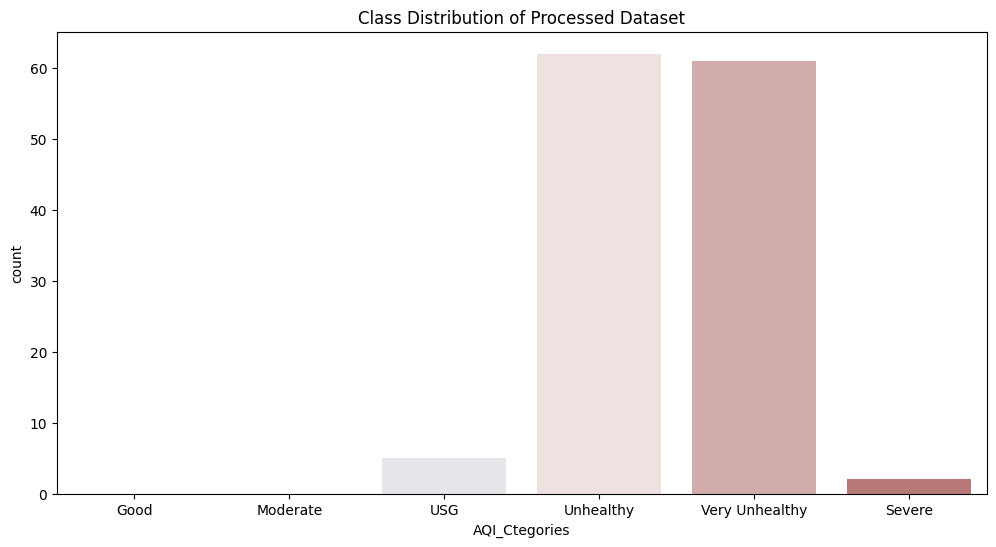

In [566]:
# --- 1. Data Overview ---
# AQI Class Distribution
# Now you can plot the number of changed categories
plt.figure(figsize=(12,6))
plt.title('Class Distribution of Processed Dataset')
custom_order = ['Good', 'Moderate', 'USG', 'Unhealthy', 'Very Unhealthy', 'Severe']
sns.countplot(data=df_full,x='AQI_Ctegories', order=custom_order, palette='vlag')

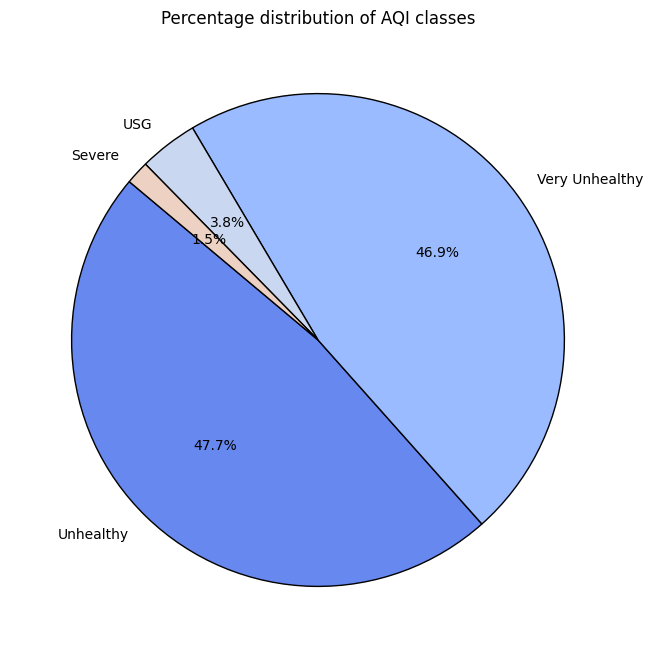

In [567]:
# --- 2. Grouping data by AQI class ---
aqi_class_distribution = df_full['AQI_Ctegories'].value_counts()

# Побудова кругової діаграми
plt.figure(figsize=(8, 8))
aqi_class_distribution.plot.pie(
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('coolwarm'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Percentage distribution of AQI classes')
plt.ylabel('')  # Remove the Y axis label
plt.show()

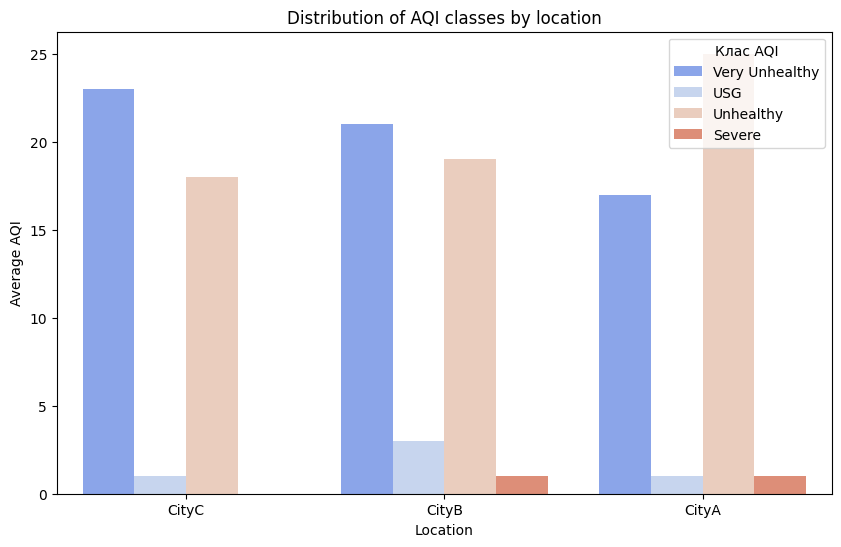

In [568]:
# --- 3. Distribution of AQI classes by location ---
df_full['Location'] = data['Location']
plt.figure(figsize=(10, 6))
sns.countplot(data=df_full, x='Location', hue='AQI_Ctegories', palette='coolwarm')
plt.title('Distribution of AQI classes by location')
plt.xlabel('Location')
plt.ylabel('Average AQI')
plt.legend(title='Клас AQI', loc='upper right')
plt.show()

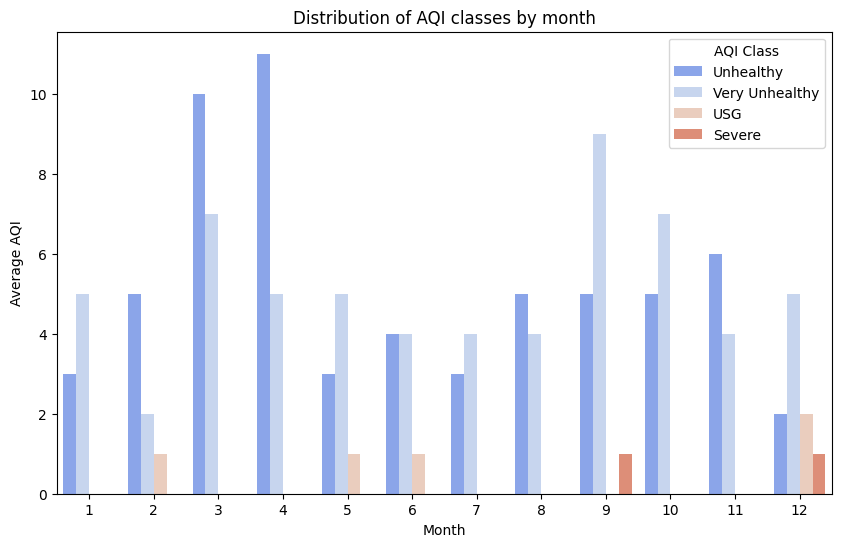

In [569]:
# --- 4. Convert time to hour ---
plt.figure(figsize=(10, 6))
sns.countplot(data=df_full, x='Month', hue='AQI_Ctegories', palette='coolwarm')
plt.title('Distribution of AQI classes by month')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.legend(title='AQI Class', loc='upper right')
plt.show()

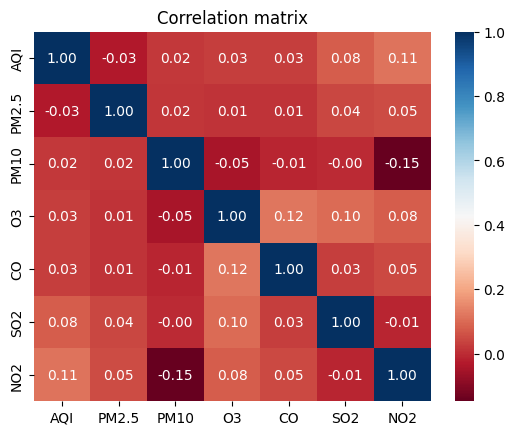

In [570]:
# --- 5. Correlation between variables ---
# Correlation matrix
corr_matrix = data[['AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f")
plt.title('Correlation matrix')
plt.show()